In [29]:

import uproot
import numpy as np
import mplhep as hep
import dask_awkward as dk
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import vector
import random
import time 
import hist
from uncertainties import unumpy as unp

In [30]:

import topcoffea.modules.eft_helper as efth

In [36]:


#########################################################################################################################################################
def compute_rapidity(pt, eta, phi, mass):
    # Convert Awkward Arrays to vector objects
    vectors = vector.awk(
        ak.zip({
            "pt": pt,
            "eta": eta,
            "phi": phi,
            "mass": mass
        }, with_name="Momentum4D")
    )
    
    # Compute rapidities
    rapidities = vectors.rapidity
    
    return rapidities

#########################################################################################################################################################

def comp_hel_basis(top, tbar,top_rap, atop_rap):
    """
        This computes the helicity basis
        :
    """

    #p_axis direction of parton beam (z-axis)
    #k_axis direction of top boosted into ttbar
    #r_axis direction defined as (phat - y*khat), y = khat * phat 
    #n_axis direction of cross product of p, k
    ttbar_frame = top + tbar
    tt_mass = ttbar_frame.mass
    boosted_top = top.boostCM_of(ttbar_frame)
    boosted_tbar = tbar.boostCM_of(ttbar_frame)
    k_axis = boosted_top.to_xyz().unit() # k-axis is defined by ttbar system

    scattering_angle = k_axis.theta
    cos_scattering_angle=np.cos(scattering_angle)
    sin_scattering_angle=np.sin(scattering_angle)

    one_array=np.ones(len(top))
    zero_array=np.zeros(len(top))
    z_axis= vector.zip({"x": zero_array ,"y": zero_array,"z": one_array })
    sY=np.where(cos_scattering_angle >= 0,one_array,-1)
    sD=np.where(abs(top_rap) >= abs(atop_rap),one_array,-1)

    j_axis = sD*k_axis
    r_arr = (sY / sin_scattering_angle) * (z_axis - (cos_scattering_angle * k_axis))
    r_axis= r_arr.unit()
    q_axis = sD * r_axis
    n_arr = (sY / sin_scattering_angle) *  z_axis.cross(k_axis)       # Store in a temp np array since pyROOT typecasts automatically
    n_axis = n_arr.unit()
    
    #p_axis = vector.obj(x = 0, y = 0, z = 1)
    #k_axis = ((top.boostCM_of(top+tbar)).to_xyz()).unit()
    #r_axis = (p_axis.subtract(k_axis.scale(np.cos(k_axis.theta)))).unit()
    #n_axis = (p_axis.cross(k_axis)).unit()

    return k_axis, r_axis, n_axis


#########################################################################################################################################################

def spincorr_calc(basis, top, tbar, l, lbar):
    """

    """
    #boost parent top into ttbar frame, boost lep into ttbar frame, then boost lep into boosted parent top frame
    boosted_top = top.boostCM_of(top.add(tbar))
    boosted_lbar = lbar.boostCM_of(top.add(tbar))
    boosted_lbar = boosted_lbar.boostCM_of(boosted_top)

    boosted_tbar = tbar.boostCM_of(top.add(tbar))
    boosted_l = l.boostCM_of(top.add(tbar))
    boosted_l = boosted_l.boostCM_of(boosted_tbar)

    #bij: boosted particle i unit vector dotted into base j
    #i = 1 for antilepton, i = 2 for lepton (flip sign)
    b1k = np.cos(boosted_lbar.deltaangle(basis[0]).to_numpy())
    b2k = np.cos(boosted_l.deltaangle(-1*basis[0]).to_numpy())
    b1r = np.cos(boosted_lbar.deltaangle(basis[1]).to_numpy())
    b2r = np.cos(boosted_l.deltaangle(-1*basis[1]).to_numpy())
    b1n = np.cos(boosted_lbar.deltaangle(basis[2]).to_numpy())
    b2n = np.cos(boosted_l.deltaangle(-1*basis[2]).to_numpy())

    #c_ij: b1i * b2j
    c_kk = b1k*b2k
    c_kr = b1k*b2r
    c_kn = b1k*b2n
    c_rk = b1r*b2k
    c_rr = b1r*b2r
    c_rn = b1r*b2n
    c_nk = b1n*b2k
    c_nr = b1n*b2r
    c_nn = b1n*b2n

    #ll_cHel: opening angle of leptons
    ll_cHel = ((boosted_l.to_xyz()).unit()).dot((boosted_lbar.to_xyz()).unit())

    ll_delta_phi = (abs(l.phi - lbar.phi)).to_numpy()
    ll_delta_eta = (abs(l.eta - lbar.eta)).to_numpy()

    ll_delta_R = (abs(np.sqrt((l.phi - lbar.phi)**2 + (l.eta - lbar.eta)**2))).to_numpy()

    #cP_ij: c_ij + c_ji
    #cM_ij: c_ij - c_ji
    cP_kr = c_kr + c_rk
    cM_kr = c_kr - c_rk
    cP_kn = c_kn + c_nk
    cM_kn = c_kn - c_nk
    cP_rn = c_rn + c_nr
    cM_rn = c_rn - c_nr

    return b1k, b2k, b1r, b2r, b1n, b2n, c_kk, c_kr, c_kn, c_rk, c_rr, c_rn, c_nk, c_nr, c_nn, ll_cHel, ll_delta_phi, ll_delta_eta, ll_delta_R, cP_kr, cM_kr, cP_kn, cM_kn, cP_rn, cM_rn

##########################################################################################################################################################################################################

def find_true_indices(jagged_array):
    # Convert None to False
    cleaned_array = ak.fill_none(jagged_array, False)
    # Create a mask for True values
    mask = cleaned_array == True
    # Get the indices of True values in each subarray
    true_indices = ak.local_index(cleaned_array)[mask]
    
    # Print the results
    #print("True values indices within subarrays:", true_indices)
    return true_indices

#########################################################################################################################################################

# Function to find common numbers in two jagged arrays
def find_common_elements(jagged_array1, jagged_array2):
    common_elements = ak.Array([np.intersect1d(subarray1, subarray2) for subarray1, subarray2 in zip(jagged_array1, jagged_array2)])
    return common_elements


In [32]:
import os
file_pvt = uproot.open('/depot/cms/top/bhanda25/EFT/cmseft2023/generation/nanogen_TT01j2lCARef_500k.root')


In [33]:

def extract_gen_info_pvt(file):
    # Open the file and extract GenPart branches
    genpart_pt = file['Events']['GenPart_pt'].array()
    genpart_eta = file['Events']['GenPart_eta'].array()
    genpart_phi = file['Events']['GenPart_phi'].array()
    genpart_mass = file['Events']['GenPart_mass'].array()
    genpart_pid = file['Events']['GenPart_pdgId'].array()
    genpart_mother = file['Events']['GenPart_genPartIdxMother'].array()
    
    return genpart_pt, genpart_eta, genpart_phi, genpart_mass, genpart_pid, genpart_mother


def extract_gen_info_central(file):
    # Open the file and extract GenPart branches
    genpart_pt = file['GenPart_pt']
    genpart_eta = file['GenPart_eta']
    genpart_phi = file['GenPart_phi']
    genpart_mass = file['GenPart_mass']
    genpart_pid = file['GenPart_pdgId']
    genpart_mother = file['GenPart_genPartIdxMother']
    
    return genpart_pt, genpart_eta, genpart_phi, genpart_mass, genpart_pid, genpart_mother
    
gen_pvt=extract_gen_info(file_pvt)
#gen_central=extract_gen_info_central(file_central)

In [34]:
def apply_genpart_masks(genpart_pid, genpart_mother):
    # Define the masks for specific particles
    top_mask = genpart_pid == 6
    atop_mask = genpart_pid == -6

    Wplus_mask = genpart_pid == 24
    Wminus_mask = genpart_pid == -24

    # Define masks for leptons and anti-leptons (considering only electrons and muons)
    lepton_mask = (genpart_pid == 11) | (genpart_pid == 13) 
    alepton_mask = (genpart_pid == -11) | (genpart_pid == -13) 

    # Leptons from W bosons
    lepton_from_Wminus_mask = genpart_pid[ak.mask(genpart_mother, lepton_mask)] == -24
    alepton_from_Wplus_mask = genpart_pid[ak.mask(genpart_mother, alepton_mask)] == 24

    # W bosons from tops
    Wplus_from_top_mask = genpart_pid[ak.mask(genpart_mother, Wplus_mask)] == 6
    Wminus_from_atop_mask = genpart_pid[ak.mask(genpart_mother, Wminus_mask)] == -6

    # Define masks for b-quarks, anti-b quarks, neutrinos, and anti-neutrinos
    b_mask = genpart_pid == 5
    ab_mask = genpart_pid == -5
    neu_mask = (genpart_pid == 12) | (genpart_pid == 14) 
    aneu_mask = (genpart_pid == -12) | (genpart_pid == -14)

    # Dilepton from W boson condition
    dilepton_from_W_mask = (
        (ak.num(find_common_elements(ak.drop_none(ak.mask(genpart_mother, alepton_mask)), find_true_indices(Wplus_from_top_mask)), axis=1) == 1)
        + (ak.num(find_common_elements(ak.drop_none(ak.mask(genpart_mother, lepton_mask)), find_true_indices(Wminus_from_atop_mask)), axis=1) == 1)
    )
    return dilepton_from_W_mask,Wplus_from_top_mask,Wminus_from_atop_mask,top_mask,atop_mask,lepton_from_Wminus_mask,alepton_from_Wplus_mask

dilepton_mask_pvt=apply_genpart_masks(gen_pvt[4],gen_pvt[5])
#dilepton_mask_central=apply_genpart_masks(gen_central[4],gen_central[5])


In [37]:
def calculate_gen_spincorr_vars(genpart_pt, genpart_eta, genpart_phi, genpart_mass, 
                                genpart_pid, genpart_mother, dilepton_from_W_mask, 
                                Wplus_from_top_mask, Wminus_from_atop_mask, 
                                top_mask, atop_mask, lepton_from_Wminus_mask, alepton_from_Wplus_mask):

    # Find top and anti-top quarks based on dilepton from W condition
    top_indices = find_common_elements(ak.drop_none(ak.mask(genpart_mother, Wplus_from_top_mask)), 
                                       find_true_indices(top_mask))[dilepton_from_W_mask]
    atop_indices = find_common_elements(ak.drop_none(ak.mask(genpart_mother, Wminus_from_atop_mask)), 
                                        find_true_indices(atop_mask))[dilepton_from_W_mask]

    # Top quark properties
    top_pt = genpart_pt[dilepton_from_W_mask][top_indices]
    top_eta = genpart_eta[dilepton_from_W_mask][top_indices]
    top_phi = genpart_phi[dilepton_from_W_mask][top_indices]
    top_mass = genpart_mass[dilepton_from_W_mask][top_indices]

    # Anti-top quark properties
    atop_pt = genpart_pt[dilepton_from_W_mask][atop_indices]
    atop_eta = genpart_eta[dilepton_from_W_mask][atop_indices]
    atop_phi = genpart_phi[dilepton_from_W_mask][atop_indices]
    atop_mass = genpart_mass[dilepton_from_W_mask][atop_indices]

    # Lepton properties
    lep_pt = ak.drop_none(genpart_pt[lepton_from_Wminus_mask][dilepton_from_W_mask])
    lep_eta = ak.drop_none(genpart_eta[lepton_from_Wminus_mask][dilepton_from_W_mask])
    lep_phi = ak.drop_none(genpart_phi[lepton_from_Wminus_mask][dilepton_from_W_mask])
    lep_mass = ak.drop_none(genpart_mass[lepton_from_Wminus_mask][dilepton_from_W_mask])

    # Anti-lepton properties
    alep_pt = ak.drop_none(genpart_pt[alepton_from_Wplus_mask][dilepton_from_W_mask])
    alep_eta = ak.drop_none(genpart_eta[alepton_from_Wplus_mask][dilepton_from_W_mask])
    alep_phi = ak.drop_none(genpart_phi[alepton_from_Wplus_mask][dilepton_from_W_mask])
    alep_mass = ak.drop_none(genpart_mass[alepton_from_Wplus_mask][dilepton_from_W_mask])

    # Compute rapidity for tops, anti-tops, leptons, and anti-leptons
    top_rap = compute_rapidity(top_pt, top_eta, top_phi, top_mass)
    atop_rap = compute_rapidity(atop_pt, atop_eta, atop_phi, atop_mass)
    lep_rap = compute_rapidity(lep_pt, lep_eta, lep_phi, lep_mass)
    alep_rap = compute_rapidity(alep_pt, alep_eta, alep_phi, alep_mass)

    # Construct the four-vectors for top, anti-top, lepton, and anti-lepton
    gen_top = vector.zip({'pt': top_pt, 'phi': top_phi, 'eta': top_rap, 'M': top_mass})
    gen_atop = vector.zip({'pt': atop_pt, 'phi': atop_phi, 'eta': atop_rap, 'M': atop_mass})
    gen_lep = vector.zip({'pt': lep_pt, 'phi': lep_phi, 'eta': lep_rap, 'M': lep_mass})
    gen_alep = vector.zip({'pt': alep_pt, 'phi': alep_phi, 'eta': alep_rap, 'M': alep_mass})

    # Ensure valid events where we have exactly one of each particle
    vec_mask = (ak.num(gen_top) == 1) & (ak.num(gen_atop) == 1) & (ak.num(gen_lep) == 1) & (ak.num(gen_alep) == 1)

    # Compute the helicity basis and spin correlation variables
    gen_basis = comp_hel_basis(gen_top[vec_mask], gen_atop[vec_mask],top_rap[vec_mask], atop_rap[vec_mask])
    gen_spincorr_vars = spincorr_calc(gen_basis, gen_top[vec_mask], gen_atop[vec_mask], gen_lep[vec_mask], gen_alep[vec_mask])

    return gen_spincorr_vars,gen_top[vec_mask],gen_atop[vec_mask],gen_lep[vec_mask],gen_alep[vec_mask],vec_mask
    
gen_spincorr_var_pvt, gen_top_pvt, gen_atop_pvt, gen_lep_pvt, gen_alep_pvt,vec_mask_pvt = calculate_gen_spincorr_vars(
    gen_pvt[0], gen_pvt[1], gen_pvt[2], gen_pvt[3], gen_pvt[4], gen_pvt[5], dilepton_mask_pvt[0], 
    dilepton_mask_pvt[1], dilepton_mask_pvt[2], dilepton_mask_pvt[3], dilepton_mask_pvt[4], dilepton_mask_pvt[5], dilepton_mask_pvt[6]
)
#gen_spincorr_var_central, gen_top_central, gen_atop_central, gen_lep_central, gen_alep_central,vec_mask_central = calculate_gen_spincorr_vars(
    #gen_central[0], gen_central[1], gen_central[2], gen_central[3], gen_central[4], gen_central[5], dilepton_mask_central[0], 
    #dilepton_mask_central[1], dilepton_mask_central[2], dilepton_mask_central[3], dilepton_mask_central[4], dilepton_mask_central[5], dilepton_mask_central[6]
#)

In [38]:
sum(vec_mask_pvt)

42647

In [39]:
branches = {
    'gen_top_pt': ak.flatten(gen_top_pvt.pt.to_numpy()),
    'gen_top_phi': ak.flatten(gen_top_pvt.phi.to_numpy()),
    'gen_top_eta': ak.flatten(gen_top_pvt.eta.to_numpy()),
    'gen_top_mass': ak.flatten(gen_top_pvt.mass.to_numpy()),
    'gen_tbar_pt': ak.flatten(gen_atop_pvt.pt.to_numpy()),
    'gen_tbar_phi': ak.flatten(gen_atop_pvt.phi.to_numpy()),
    'gen_tbar_eta': ak.flatten(gen_atop_pvt.eta.to_numpy()),
    'gen_tbar_mass': ak.flatten(gen_atop_pvt.mass.to_numpy()),
    'gen_l_pt': ak.flatten(gen_lep_pvt.pt.to_numpy()),
    'gen_l_eta': ak.flatten(gen_lep_pvt.eta.to_numpy()),
    'gen_l_phi': ak.flatten(gen_lep_pvt.phi.to_numpy()),
    'gen_l_mass': ak.flatten(gen_lep_pvt.mass.to_numpy()),
    'gen_lbar_pt': ak.flatten(gen_alep_pvt.pt.to_numpy()),
    'gen_lbar_eta': ak.flatten(gen_alep_pvt.eta.to_numpy()),
    'gen_lbar_phi': ak.flatten(gen_alep_pvt.phi.to_numpy()),
    'gen_lbar_mass': ak.flatten(gen_alep_pvt.mass.to_numpy()),
    'gen_llbar_delta_phi': ak.flatten(gen_spincorr_var_pvt[16]),  # Assuming ll_delta_phi is the 16th variable
    'gen_llbar_delta_eta': ak.flatten(gen_spincorr_var_pvt[17]),  # Assuming ll_delta_eta is the 17th variable
    'gen_b1k': ak.flatten(gen_spincorr_var_pvt[0]),               # b1k from spincorr_calc
    'gen_b2k': ak.flatten(gen_spincorr_var_pvt[1]),               # b2k from spincorr_calc
    'gen_b1r': ak.flatten(gen_spincorr_var_pvt[2]),               # b1r from spincorr_calc
    'gen_b2r': ak.flatten(gen_spincorr_var_pvt[3]),               # b2r from spincorr_calc
    'gen_b1n': ak.flatten(gen_spincorr_var_pvt[4]),               # b1n from spincorr_calc
    'gen_b2n': ak.flatten(gen_spincorr_var_pvt[5]),               # b2n from spincorr_calc
    'gen_c_kk': ak.flatten(gen_spincorr_var_pvt[6]),              # c_kk from spincorr_calc
    'gen_c_rr': ak.flatten(gen_spincorr_var_pvt[10]),             # c_rr from spincorr_calc
    'gen_c_nn': ak.flatten(gen_spincorr_var_pvt[14]),             # c_nn from spincorr_calc
    'gen_c_rk': ak.flatten(gen_spincorr_var_pvt[9]),              # c_rk from spincorr_calc
    'gen_c_kr': ak.flatten(gen_spincorr_var_pvt[7]),              # c_kr from spincorr_calc
    'gen_c_nr': ak.flatten(gen_spincorr_var_pvt[13]),             # c_nr from spincorr_calc
    'gen_c_rn': ak.flatten(gen_spincorr_var_pvt[11]),             # c_rn from spincorr_calc
    'gen_c_nk': ak.flatten(gen_spincorr_var_pvt[12]),             # c_nk from spincorr_calc
    'gen_c_kn': ak.flatten(gen_spincorr_var_pvt[8]),              # c_kn from spincorr_calc
    'gen_ll_cHel': ak.flatten(gen_spincorr_var_pvt[15]),          # ll_cHel from spincorr_calc
}

# Extracting the ctgRe10 weight
weight_ctgRe10 = file_pvt['Events']['LHEWeight_EFTrwgt1_ctGRe_10.0_ctGIm_0.0_cQj18_0.0_cQj38_0.0_cQj11_0.0_cQj31_0.0_ctu8_0.0_ctd8_0.0_ctj8_0.0_cQu8_0.0_cQd8_0.0_ctu1_0.0_ctd1_0.0_ctj1_0.0_cQu1_0.0_cQd1_0.0'].array()
weight_sm = file_pvt['Events']['LHEWeight_EFTrwgt0_ctGRe_0.0_ctGIm_0.0_cQj18_0.0_cQj38_0.0_cQj11_0.0_cQj31_0.0_ctu8_0.0_ctd8_0.0_ctj8_0.0_cQu8_0.0_cQd8_0.0_ctu1_0.0_ctd1_0.0_ctj1_0.0_cQu1_0.0_cQd1_0.0'].array()

# Applying the mask
weight_ct = weight_ctgRe10[vec_mask_pvt]
weight_sm0 = weight_sm[vec_mask_pvt]

# Adding the new weights to branches
branches['ctgRe10_weight'] = weight_ct
branches['sm_weight'] = weight_sm0

# Open a new ROOT file for writing
with uproot.recreate("spincorr_kinematic_output_pvt.root") as file:
    # Create a tree and add the branches
    file["Events"] = branches

print("ROOT file created with spin correlation variables, ctgRe10 weight, and sm weight.")

ROOT file created with spin correlation variables, ctgRe10 weight, and sm weight.


In [28]:
branches_central = {
    'gen_top_pt': ak.flatten(gen_top_central.pt.to_numpy()),
    'gen_top_phi': ak.flatten(gen_top_central.phi.to_numpy()),
    'gen_top_eta': ak.flatten(gen_top_central.eta.to_numpy()),
    'gen_top_mass': ak.flatten(gen_top_central.mass.to_numpy()),
    'gen_tbar_pt': ak.flatten(gen_atop_central.pt.to_numpy()),
    'gen_tbar_phi': ak.flatten(gen_atop_central.phi.to_numpy()),
    'gen_tbar_eta': ak.flatten(gen_atop_central.eta.to_numpy()),
    'gen_tbar_mass': ak.flatten(gen_atop_central.mass.to_numpy()),
    'gen_l_pt': ak.flatten(gen_lep_central.pt.to_numpy()),
    'gen_l_eta': ak.flatten(gen_lep_central.eta.to_numpy()),
    'gen_l_phi': ak.flatten(gen_lep_central.phi.to_numpy()),
    'gen_l_mass': ak.flatten(gen_lep_central.mass.to_numpy()),
    'gen_lbar_pt': ak.flatten(gen_alep_central.pt.to_numpy()),
    'gen_lbar_eta': ak.flatten(gen_alep_central.eta.to_numpy()),
    'gen_lbar_phi': ak.flatten(gen_alep_central.phi.to_numpy()),
    'gen_lbar_mass': ak.flatten(gen_alep_central.mass.to_numpy()),
    'gen_llbar_delta_phi': ak.flatten(gen_spincorr_var_central[16]),
    'gen_llbar_delta_eta': ak.flatten(gen_spincorr_var_central[17]),
    'gen_b1k': ak.flatten(gen_spincorr_var_central[0]),
    'gen_b2k': ak.flatten(gen_spincorr_var_central[1]),
    'gen_b1r': ak.flatten(gen_spincorr_var_central[2]),
    'gen_b2r': ak.flatten(gen_spincorr_var_central[3]),
    'gen_b1n': ak.flatten(gen_spincorr_var_central[4]),
    'gen_b2n': ak.flatten(gen_spincorr_var_central[5]),
    'gen_c_kk': ak.flatten(gen_spincorr_var_central[6]),
    'gen_c_rr': ak.flatten(gen_spincorr_var_central[10]),
    'gen_c_nn': ak.flatten(gen_spincorr_var_central[14]),
    'gen_c_rk': ak.flatten(gen_spincorr_var_central[9]),
    'gen_c_kr': ak.flatten(gen_spincorr_var_central[7]),
    'gen_c_nr': ak.flatten(gen_spincorr_var_central[13]),
    'gen_c_rn': ak.flatten(gen_spincorr_var_central[11]),
    'gen_c_nk': ak.flatten(gen_spincorr_var_central[12]),
    'gen_c_kn': ak.flatten(gen_spincorr_var_central[8]),
    'gen_ll_cHel': ak.flatten(gen_spincorr_var_central[15]),
}

a=file_central['LHEReweightingWeight']
a1=a[vec_mask_central]
weight_sm_central= [row[201] for row in a1]
weight_ctGRe1_central=[row[202] for row in a1]

# Adding the new weights to branches
branches_central['ctgRe1_weight'] = weight_ctGRe1_central
branches_central['sm_weight'] = weight_sm_central

# Writing central branches to another ROOT file
with uproot.recreate("spincorr_output_central.root") as file:
    file["Events"] = branches_central

print("ROOT file created with central spin correlation variables.")

ROOT file created with central spin correlation variables.


In [44]:
weight_ctGRe1

<Array [0.191, 0.286, 0.0517, ..., 1.93, 0.136, 2.33] type='235379 * float32'>

In [26]:
def plot_observables(obs1, obs2, xlabel, title):
    fig, (ax, ax_ratio) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Plot the first set of observables without weights
    counts1, bins1, _ = ax.hist(obs1, bins=20, label='Private_EFT_SM', color='blue', histtype='step', density=True)
    
    # Plot the second set of observables without weights
    counts2, bins2, _ = ax.hist(obs2, bins=20, label='central_SM', color='red', histtype='step', density=True)
    
    # Calculate the ratio
    bin_centers = 0.5 * (bins1[:-1] + bins1[1:])
    ratio = np.divide(counts1, counts2, out=np.zeros_like(counts1), where=counts2 != 0)
    
    # Plot the ratio
    ax_ratio.plot(bin_centers, ratio, color='black', marker='o', linestyle='none')
    ax_ratio.set_ylabel('Private/central')
    ax_ratio.set_ylim(0, 2)  # Adjust the limits as needed
    
    # Adding labels, title, and legend
    ax.set_ylabel("Normalized events")
    ax.set_title(title)
    ax.legend(loc='best')
    
    # Add CMS label
    hep.cms.label(ax=ax)
    
    # Label for x-axis on the ratio plot
    ax_ratio.set_xlabel(xlabel)
    ax_ratio.set_ylim(0.8, 1.2)
    ax_ratio.axhline(1, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()


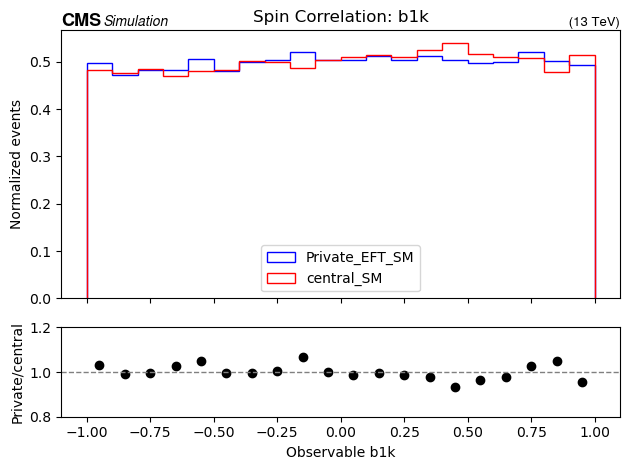

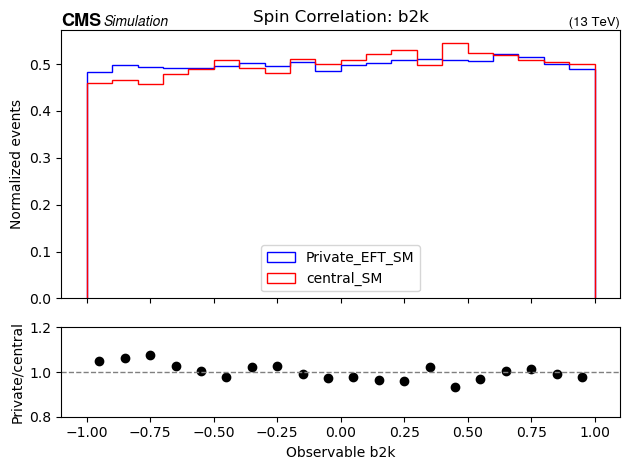

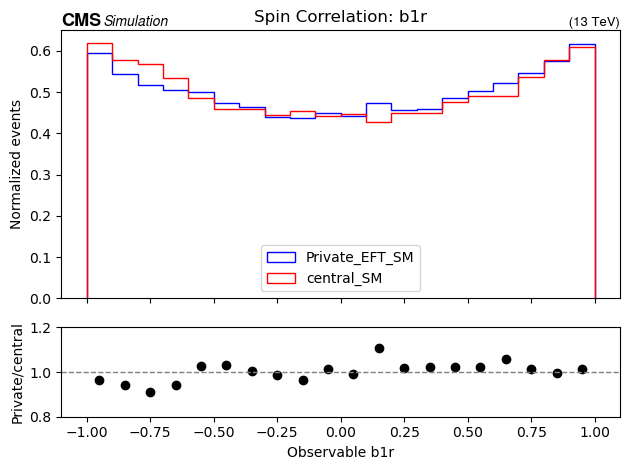

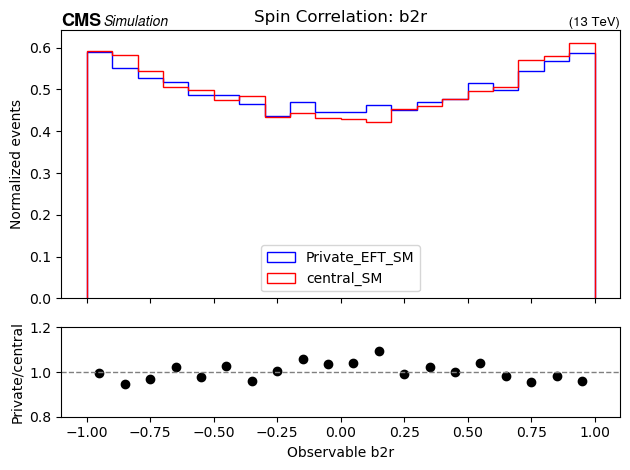

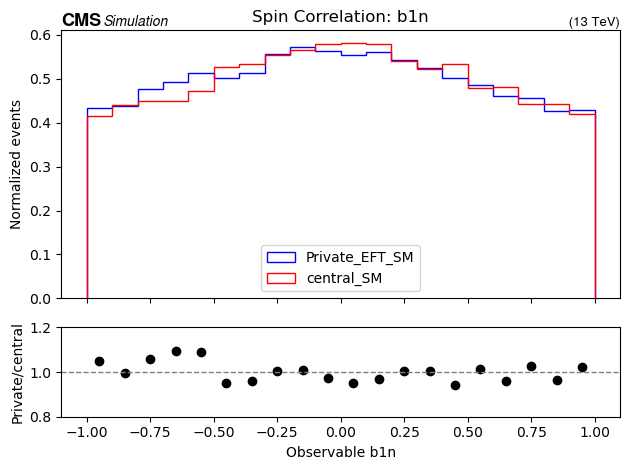

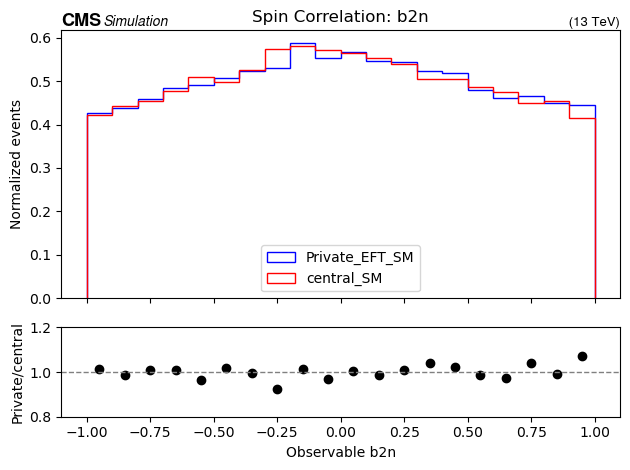

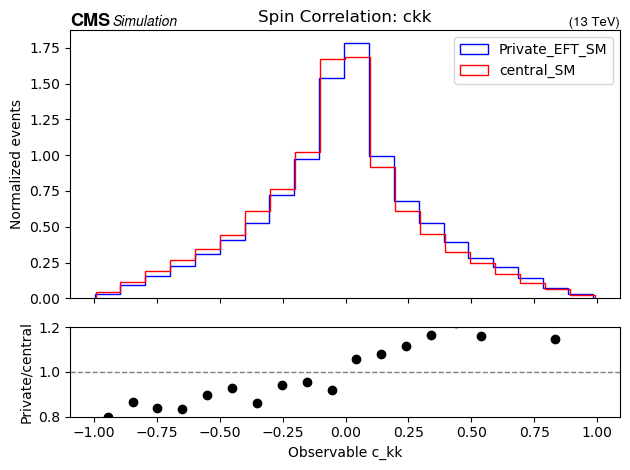

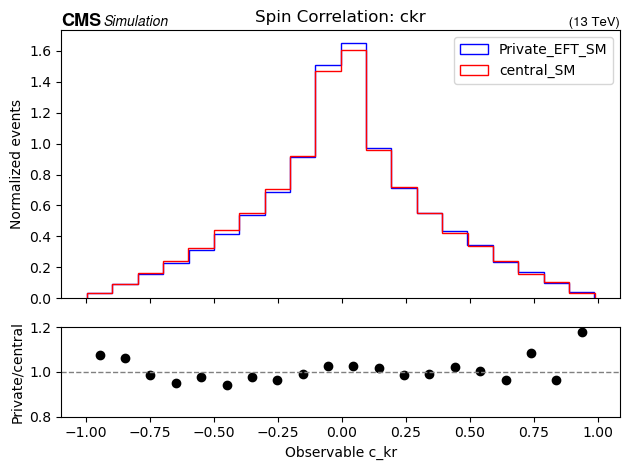

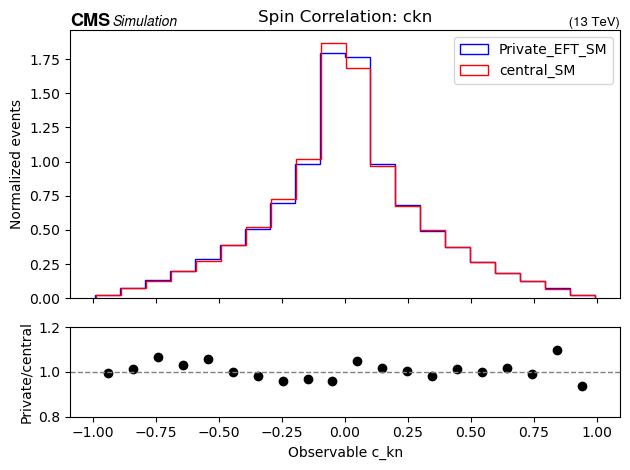

In [27]:
# Example observable labels and titles
observables_labels = ['b1k', 'b2k', 'b1r', 'b2r', 'b1n', 'b2n', 'c_kk', 'c_kr', 'c_kn']
observables_titles = ['Spin Correlation: b1k', 'Spin Correlation: b2k', 'Spin Correlation: b1r', 'Spin Correlation: b2r', 'Spin Correlation: b1n', 'Spin Correlation: b2n', 'Spin Correlation: ckk', 'Spin Correlation: ckr', 'Spin Correlation: ckn']

# Plot each observable
for i, label in enumerate(observables_labels):
    plot_observables(gen_spincorr_var_pvt[i], gen_spincorr_var_central[i], xlabel=f"Observable {label}", title=observables_titles[i])


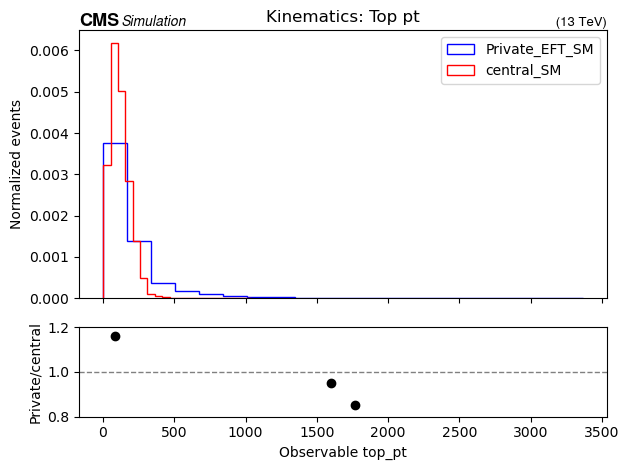

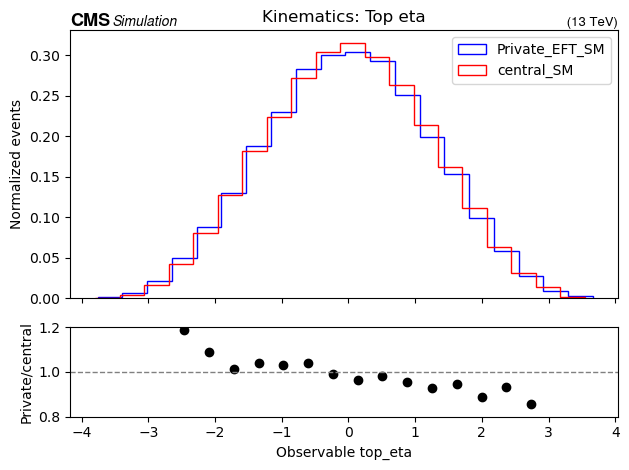

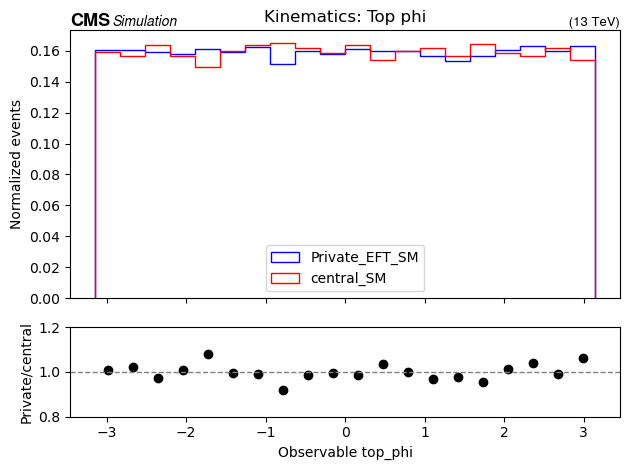

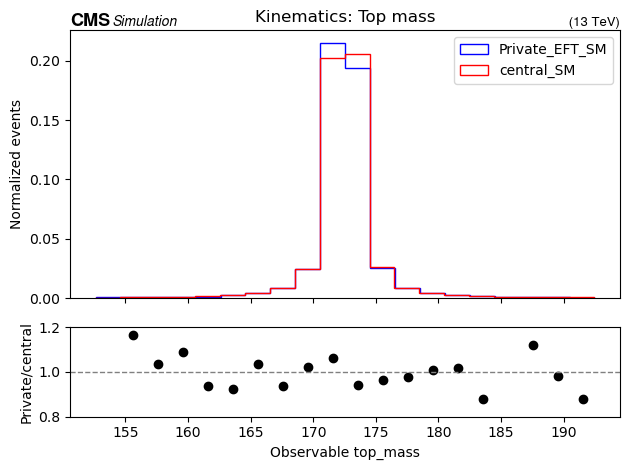

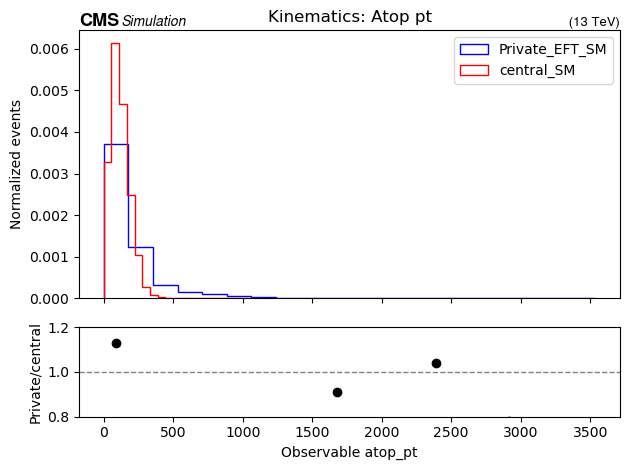

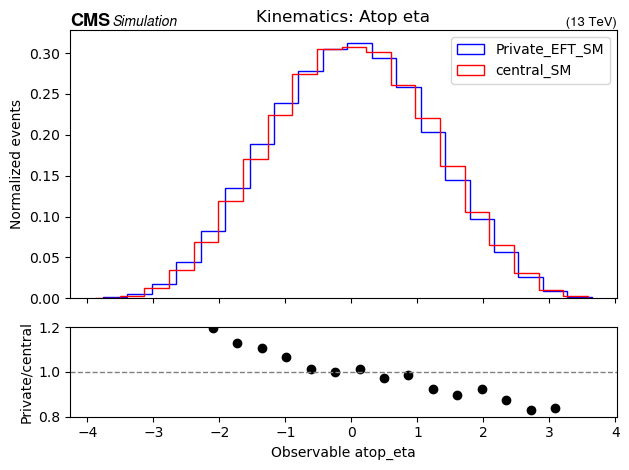

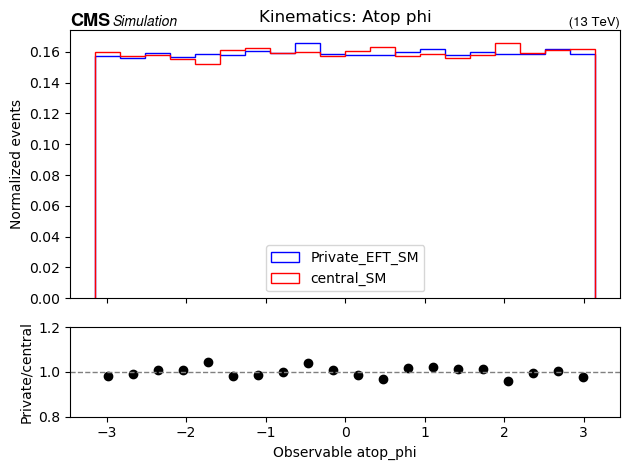

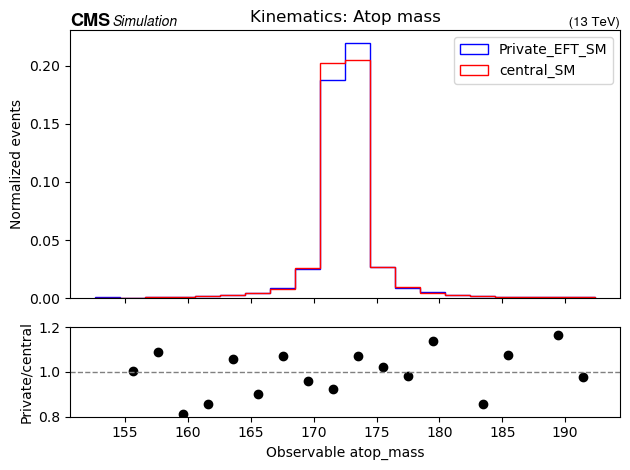

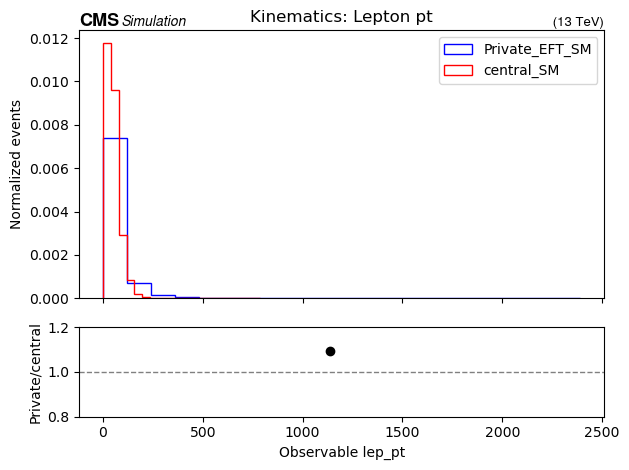

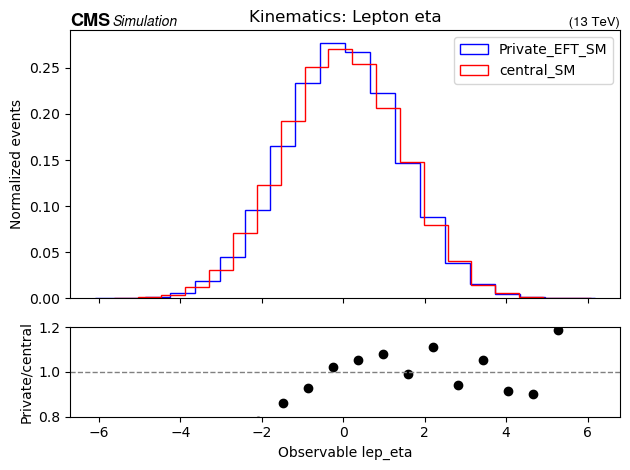

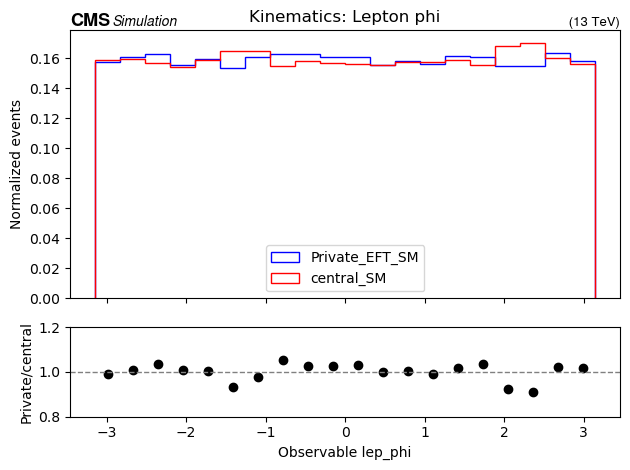

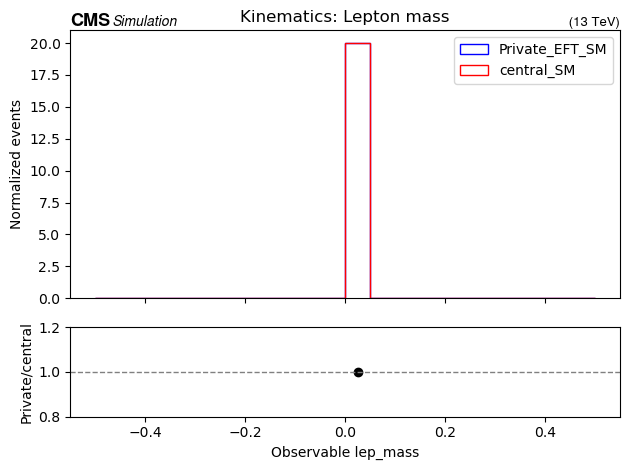

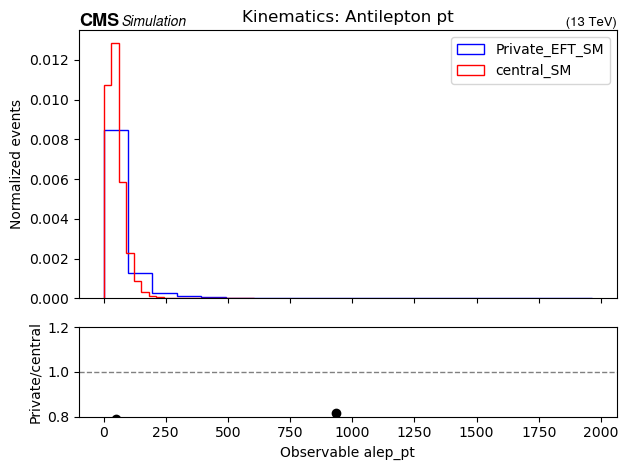

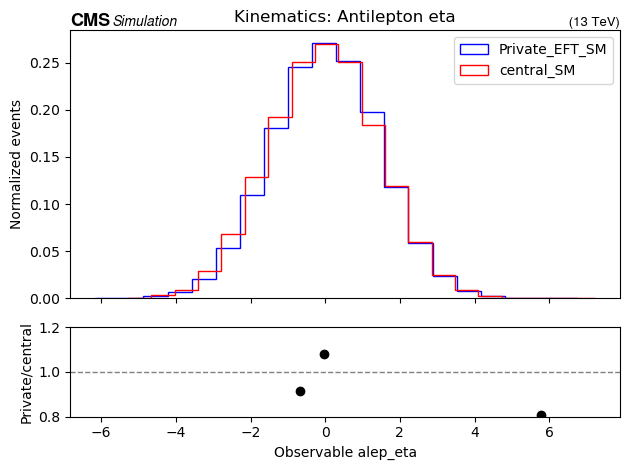

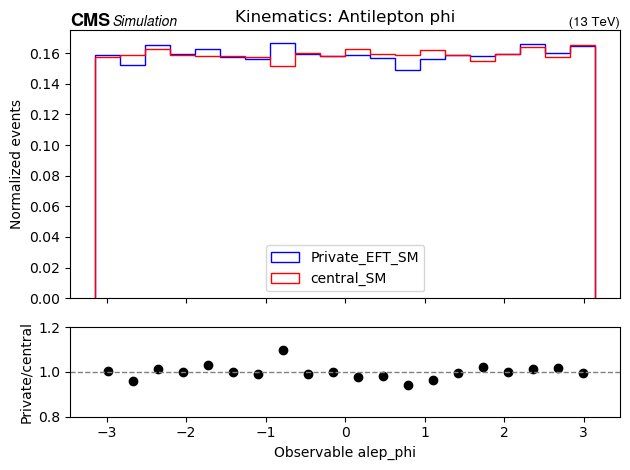

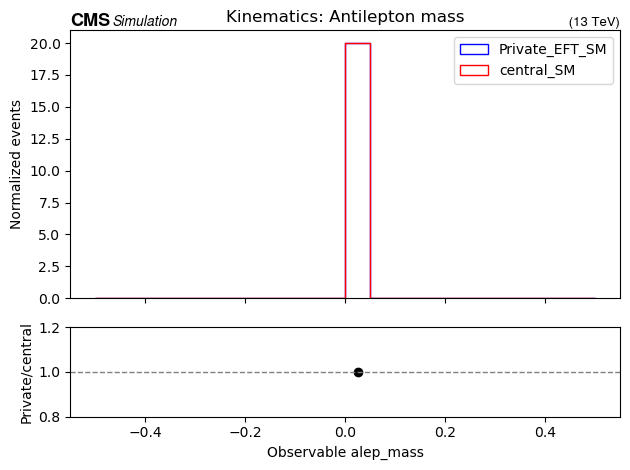

In [33]:
kinematic_labels = ['top_pt', 'top_eta', 'top_phi', 'top_mass', 
                    'atop_pt', 'atop_eta', 'atop_phi', 'atop_mass',
                    'lep_pt', 'lep_eta', 'lep_phi', 'lep_mass',
                    'alep_pt', 'alep_eta', 'alep_phi', 'alep_mass']

kinematic_titles = ['Kinematics: Top pt', 'Kinematics: Top eta', 'Kinematics: Top phi', 'Kinematics: Top mass', 
                    'Kinematics: Atop pt', 'Kinematics: Atop eta', 'Kinematics: Atop phi', 'Kinematics: Atop mass',
                    'Kinematics: Lepton pt', 'Kinematics: Lepton eta', 'Kinematics: Lepton phi', 'Kinematics: Lepton mass',
                    'Kinematics: Antilepton pt', 'Kinematics: Antilepton eta', 'Kinematics: Antilepton phi', 'Kinematics: Antilepton mass']

# Prepare the kinematic observables for private dataset using direct attribute access
kinematic_observables_pvt = [
    gen_top_pvt.pt, gen_top_pvt.eta, gen_top_pvt.phi, gen_top_pvt.mass,
    gen_atop_pvt.pt, gen_atop_pvt.eta, gen_atop_pvt.phi, gen_atop_pvt.mass,
    gen_lep_pvt.pt, gen_lep_pvt.eta, gen_lep_pvt.phi, gen_lep_pvt.mass,
    gen_alep_pvt.pt, gen_alep_pvt.eta, gen_alep_pvt.phi, gen_alep_pvt.mass
]

# Prepare the kinematic observables for central dataset using direct attribute access
kinematic_observables_central = [
    gen_top_central.pt, gen_top_central.eta, gen_top_central.phi, gen_top_central.mass,
    gen_atop_central.pt, gen_atop_central.eta, gen_atop_central.phi, gen_atop_central.mass,
    gen_lep_central.pt, gen_lep_central.eta, gen_lep_central.phi, gen_lep_central.mass,
    gen_alep_central.pt, gen_alep_central.eta, gen_alep_central.phi, gen_alep_central.mass
]

for i, label in enumerate(kinematic_labels):
    plot_observables(kinematic_observables_pvt[i], kinematic_observables_central[i], xlabel=f"Observable {label}", title=kinematic_titles[i])